# Stereo Robot Navigation

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import math

In [2]:
disparity_range = range(0, 128)

# Flags
R_DEFAULT = 0   # return only disparity map
R_SAD_MAP = 1   # return disparity map and the corresponding dissimilarity map
R_SAD_MAPS = 2  # return disparity map and the dissimilarity maps for each step in the dissimilarity range

def computeFastDisparityMap(left_image, right_image, area_size, block_size, disparity_range=disparity_range, flag=R_DEFAULT):

    # Check parameters
    if (block_size%2 != 1 | 
        block_size==1 | 
        block_size > left_image.shape[0] |
        block_size > left_image.shape[1]):
        raise Exception("block_size must be odd, greater than 1, and be not larger than image width or height")

    if (area_size > left_image.shape[0] |
        area_size > left_image.shape[1]):
        raise Exception("area_size must not be larger than the image width or height")
    
    kernel = np.ones([block_size, block_size])
    sad_maps = np.zeros([area_size, area_size, len(disparity_range)])
    left_image_f = np.float32(left_image)
    right_image_f = np.float32(right_image)
    
    # Translate the image and crop, in order to obtain a central area_size x area_size pixels area
    left_translation = np.float32([[1, 0, -(left_image.shape[1]-area_size)//2], 
                              [0, 1, -(left_image.shape[0]-area_size)//2]])
    
    left_ROI = cv2.warpAffine(left_image_f, left_translation, (area_size, area_size))

    for i in disparity_range:
        # The right image must be shifted each for loop
        right_translation = left_translation + ([[0,0,i],[0,0,0]])
        right_ROI = cv2.warpAffine(right_image_f, right_translation, (area_size, area_size))

        # Calculate absolute differences
        absolute_differences = np.abs(left_ROI - right_ROI)

        # Convolve with kernel and compute SAD at each point
        sad_map = cv2.filter2D(
            src = absolute_differences,
            ddepth = -1,
            kernel = kernel, 
            borderType=cv2.BORDER_ISOLATED)
        sad_maps[:, :, i-disparity_range[0]] = sad_map
    
    # The disparity values are the indices of the minimum sad values, plus the starting value
    # of the disparity range
    disparity_map = np.argmin(sad_maps, axis=-1)
    disparity_map += disparity_range[0]

    if flag == R_DEFAULT:
        return disparity_map
    elif flag == R_SAD_MAP:
        sad_map = np.min(sad_maps, axis=-1)
        return disparity_map, sad_map
    elif flag == R_SAD_MAPS:
        return disparity_map, sad_maps

In [3]:
def moravecOperator(image, area_size, block_size):

    direction = [(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1)]
    maps = np.zeros((area_size, area_size, len(direction)), dtype=int)
    image_f = np.float32(image)
    kernel = np.ones([block_size, block_size])
    
    # Translate the image and crop, in order to obtain a central area_size x area_size pixels area
    translation = np.float32([[1, 0, -(image.shape[1]-area_size)//2], 
                              [0, 1, -(image.shape[0]-area_size)//2]])
    
    ROI = cv2.warpAffine(image_f, translation, (area_size, area_size))

    for i in range(len(direction)):
        u, v = direction[i]

        # The image is shifted in every direction
        dir_translation = translation + ([[0,0,u],[0,0,v]])
        dir_ROI = cv2.warpAffine(image_f, dir_translation, (area_size, area_size))

        # Calculate squared differences
        squared_difference = np.square(ROI - dir_ROI)

        # Convolve with kernel
        map = cv2.filter2D(
            src = squared_difference,
            ddepth = -1,
            kernel = kernel, 
            borderType=cv2.BORDER_ISOLATED)
        maps[:, :, i] = map
    
    # The moravec operator is given by the minimum intensity variation
    return np.min(maps, axis=-1)

def computeRobustMainDisparity(disparity_map, mask=None):
    # If no mask is provided, compute the average across the whole disparity map
    if mask is None:
        return np.average(disparity_map)
    # If a boolean mask is provided, compute the average only in the selected area
    else:
        return np.average(disparity_map[mask])

In [4]:
baseline = 92.226   # mm
focale = 567.2      # pixel

def computeDistance(main_disparity, baseline = baseline, focal_length = focale):
    return baseline*focal_length/main_disparity

In [5]:
pattern_size = (8,6) # number of inner corner

def computeChessboardSize(img, distance, pattern_size=pattern_size):

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    # In order to use cornerSubPix, we need a single channel image
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is satisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1.)
        cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)
        
        # We can assume that the pattern is parallel to the image plane
        
        # The corners are not guaranteed to be in this order, they could be reversed, but since
        # we are interested only in the length, the computation is correct in both cases
        top_right = corners[0,0,:]
        bottom_right = corners[7,0,:]
        top_left = corners[40,0,:]
        bottom_left = corners[47,0,:]

        W = distance * np.linalg.norm(top_left-top_right) / focale
        H = distance * np.linalg.norm(top_left-bottom_left) / focale

        img_with_corner = np.copy(img)
        cv2.drawChessboardCorners(img_with_corner, pattern_size, corners, found)

        return W, H, img_with_corner
    else:
        img_with_corner = np.copy(img)
        cv2.drawChessboardCorners(img_with_corner, pattern_size, corners, found)

        return None, None, img_with_corner

In [6]:
def generateOutputImage(img, distance, disparity_size):
    # If the value is under the threshold, the box will be red, otherwise green
    if distance <= 800:
        border_color = [158, 3, 34]
    else:
        border_color = [0, 184, 31]

    output_image = np.copy(img)
    border_thick = 5
    top_left = (border_thick, border_thick)
    bottom_right = (img.shape[1]//3, img.shape[0]//6)

    # Highlight the disparity map area
    cv2.rectangle(
        img = output_image, 
        pt1 = ((img.shape[1]-disparity_size)//2, (img.shape[0]-disparity_size)//2),
        pt2 = ((img.shape[1]+disparity_size)//2, (img.shape[0]+disparity_size)//2), 
        color = (255,0,0), 
        thickness = 2,
        lineType=cv2.LINE_AA)
    
    # Add a white rectangle area
    cv2.rectangle(
        img = output_image, 
        pt1 = top_left, 
        pt2 = bottom_right, 
        color = (255,255,255), 
        thickness = cv2.FILLED)

    # Add the colored border to the rectangle
    cv2.rectangle(
        img = output_image, 
        pt1 = top_left, 
        pt2 = bottom_right, 
        color = border_color, 
        thickness = border_thick)

    # Add the text inside the rectangle
    text = "Distance: {:.2f}m".format(distance/1000)
    cv2.putText(
        img = output_image, 
        text = text, 
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
        fontScale = 0.75, 
        color = (0, 0, 0),
        thickness = 2,
        org = (border_thick+5, bottom_right[1]//2+8),
        lineType = cv2.LINE_AA)
        
    return output_image

In [7]:
def computeDisparityRange(main_disparity):
    if main_disparity < 32:
        return range(0, 64)
    else:
        return range(int(main_disparity)-32, int(main_disparity)+32)

In [8]:
def computeObstaclesCoords(disparity_map, num_stripes):
    # For each stripe compute the main disparity value
    disparities = []
    stripe_len = disparity_map.shape[1] // num_stripes

    for i in range(0, num_stripes):
        # Average value
        disparities.append(np.average(disparity_map[:,stripe_len*i:stripe_len*(i+1)].flatten()))

        # Most frequent value
        #disparities.append(np.bincount(disparity_map[:,stripe_len*i:stripe_len*(i+1)].flatten()).argmax())
    
    # We take the center point of each stripe for the following computation
    width = disparity_map.shape[1]
    height = disparity_map.shape[0]
    frame_points = np.zeros(shape=(len(disparities), 2))

    for i in range(0, num_stripes):
        frame_points[i] = [width/num_stripes*(i+0.5), height/2]

    # Translate the origin to the piercing point, we will consider the pixel size to be 1
    image_points = frame_points - [width/2, height/2]

    # Coordinate of the 3D points in the CRF
    # Given that we need to create a planar view, we are interested only in the XZ plane
    XZ_coords = np.zeros(shape=(len(disparities), 2))
    for i in range(0, num_stripes):
        Z = (baseline * focale) / disparities[i]
        X = image_points[i,0]* Z / focale
        XZ_coords[i] =  [X,Z]

    # Approximate a line through the obstacles point, and compute the angle with respect
    # to the image plane
    coef = np.polyfit(XZ_coords[:,0],XZ_coords[:,1],1)
    angle_deg = math.degrees(math.atan(coef[0]))

    # Normalize the coordinate for easier representation
    # Normalize between [0,1]
    XZ_coords[:,0] = 0.5 + XZ_coords[:,0] / (2*np.max(XZ_coords[:,0]))
    XZ_coords[:,1] = 1 - XZ_coords[:,1] / np.max(XZ_coords[:,1])

    return XZ_coords, angle_deg

In [9]:
def drawPlanarView(norm_coords, angle):
    view = np.ones(shape=(400, 400, 3), dtype=np.int)*255     # white background
    obst_width = 400 // (len(norm_coords)*2)  # length of half the black rectangle representing the obstacle

    # Draw axis of the XZ plane
    cv2.arrowedLine(view, (200,380), (200,20), (127,127,127), 1, tipLength=0.03)
    cv2.arrowedLine(view, (20,360), (380,360), (127,127,127), 1, tipLength=0.03)
    cv2.putText(view, "X", (354,380), cv2.FONT_HERSHEY_DUPLEX, 0.5, (127,127,127), 1)
    cv2.putText(view, "Z", (214,30), cv2.FONT_HERSHEY_DUPLEX, 0.5, (127,127,127), 1)

    # Draw camera, origin coordinates (200, 360)
    cv2.rectangle(view, (170,350), (230,370), (255,0,0), thickness=cv2.FILLED)
    cv2.rectangle(view, (178,343), (192,349), (0,0,0), thickness=cv2.FILLED)
    cv2.rectangle(view, (208,343), (222,349), (0,0,0), thickness=cv2.FILLED)

    scaled_coords = norm_coords*320+40
    
    for c in scaled_coords:
        cv2.rectangle(view, (int(c[0]-obst_width), int(c[1]-4)), (int(c[0]+obst_width), int(c[1]+4)), (0,0,0), cv2.FILLED)


    # Write angle value in a box
    cv2.rectangle(view, (20,300), (122,330), (0,0,0), thickness=2)
    cv2.putText(view, "t={:.1f} deg".format(angle), (24,320), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (127,127,127), 1, cv2.LINE_AA)

    # Draw line through obstacles
    # The slope in the image will not correspond with the real angle computed before 
    # because the coordinates were stretched during the normalization!
    coef = np.polyfit(scaled_coords[:,0],scaled_coords[:,1],1)
    poly1d_fn = np.poly1d(coef) 
    l_start = (20, int(poly1d_fn(20)))
    l_end = (360, int(poly1d_fn(360)))
    cv2.line(view, l_start, l_end, (0,127,0), 1)

    return view

## Main

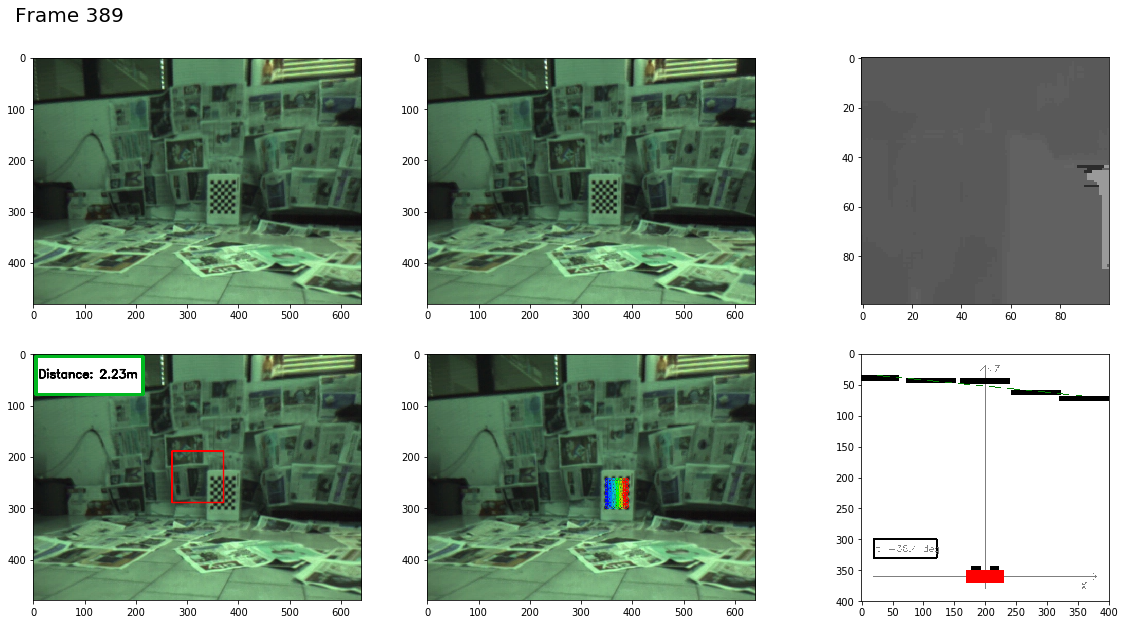

Distance from the obstacle: 2.23 mm
Frame computation time:  47.68 ms
W - estimated: 136.12mm   real: 125mm
H - estimated: 197.08mm   real: 178mm


In [10]:
capL = cv2.VideoCapture('Video/robotL.avi')
capR = cv2.VideoCapture('Video/robotR.avi')

# Parameters
area_size = 100
block_size = 15

frame_counter = 0
disparity_range = range(0,64)

w_array = []
h_array = []

try:
    while(capL.isOpened() and capR.isOpened()):
        time1 = time.time()

        # Read current frame
        retL, frameL = capL.read()
        retR, frameR = capR.read()

        if retL==False or retR==False:
            break
        
        frame_counter += 1

        frameL_gray = cv2.cvtColor(frameL, cv2.COLOR_BGR2GRAY)
        frameR_gray = cv2.cvtColor(frameR, cv2.COLOR_BGR2GRAY)
        
        # Compute disparity map
        disparity_map = computeFastDisparityMap(frameL_gray, frameR_gray, area_size, block_size, disparity_range)

        # Compute main disparity only in sufficiently textured area (Moravec operator)
        # and distance in meter
        moravec_map = moravecOperator(frameL_gray, area_size, 3)
        moravec_mask = moravec_map >= np.percentile(moravec_map, 70)
        d_main = computeRobustMainDisparity(disparity_map, moravec_mask)
        distance = computeDistance(d_main, baseline, focale)

        # Generate suitable output image
        output_image = generateOutputImage(frameL, distance, area_size)

        # Compute size of the chessboard
        W, H, img_with_corner = computeChessboardSize(frameL, distance, pattern_size=(8,6))

        # Generate planar view
        coords, angle = computeObstaclesCoords(disparity_map, 5)
        planar_view = drawPlanarView(coords, angle)

        time2 = time.time()
        
        # Display output
        plt.figure(figsize=(20,10), )
        plt.suptitle("Frame {}".format(frame_counter), fontsize=20, x=0.15, y=0.95)
        plt.subplot(2,3,1)
        plt.imshow(frameL)
        plt.subplot(2,3,2)
        plt.imshow(frameR)
        plt.subplot(2,3,3)
        plt.imshow(disparity_map, "gray", vmin=disparity_range[0], vmax=disparity_range[-1])

        plt.subplot(2,3,4)
        plt.imshow(output_image)
        plt.subplot(2,3,5)
        plt.imshow(img_with_corner)
        plt.subplot(2,3,6)
        plt.imshow(planar_view)
        plt.show()

        print("Distance from the obstacle: {:.2f} mm".format(distance/1000))
        print("Frame computation time: {:6.2f} ms".format((time2-time1)*1000))
        
        if W != None and H != None:
            w_array.append(W)
            h_array.append(H)
            print("W - estimated: {:.2f}mm   real: 125mm".format(W))
            print("H - estimated: {:.2f}mm   real: 178mm".format(H))
        else:
            print("Could not detect chessboard")

        #time.sleep(2)

        clear_output(wait=True)

        # Disparity range for next frame
        disparity_range = computeDisparityRange(d_main)

        
    capL.release()
    capR.release()
except KeyboardInterrupt:
    capL.release()
    capR.release()
    print("Released Video Resource")

## Final considerations on the results

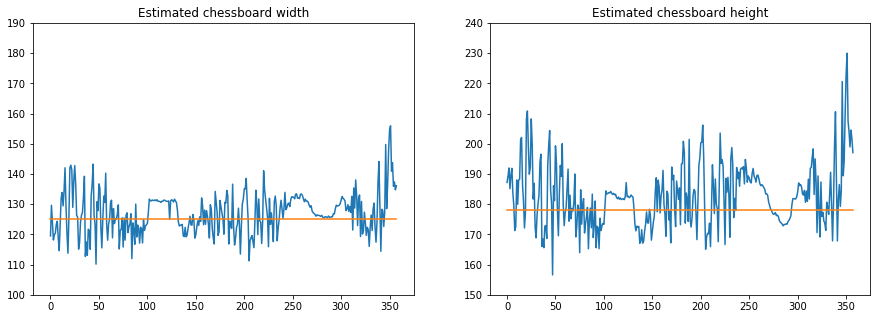

In [11]:
x = np.arange(0, len(w_array))
w_groundtruth = np.ones_like(w_array)*125
h_groundtruth = np.ones_like(w_array)*178

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Estimated chessboard width")
plt.plot(x, w_array, x, w_groundtruth)
plt.ylim(100,190)

plt.subplot(1,2,2)
plt.title("Estimated chessboard height")
plt.plot(x, h_array, x, h_groundtruth)
plt.ylim(150,240)

plt.show()

During the first approach, we can clearly see that the accuracy of the predictions improves the closer the robot gets to the chessboard, up to frame 100 (the frame considered in the graphs are only those where the chessboard has been detected, so there is a slightly mismatch with the frame counter in the video).

When it gets too close to the chessboard, the homogeneous white area causes an error in the disparity map, and it influences the main disparity (approximately from frame 100 to 130 in the graph).

<img src="./Results/Frame_130.png" alt="frame_130" style="width: 650px;"/>


During the second approach manouver (from frame 230 to 310 in the video, approximately from 200 to 280 in the graph) the accuracy tends to be worse mainly because the chessboard is not always completely in the disparity map, so when it's framing the wall behind it's overestimating the size, but when it's completely in the frame, it improves significantly.

<img src="./Results/Frame_268.png" alt="frame_268" style="width: 650px;"/>

<img src="./Results/Frame_298.png" alt="frame_298" style="width: 650px;"/>

In the last frames, when the robot is moving away from the chessboard, there are some errors for the same reason as before.

<img src="./Results/Frame_381.png" alt="frame_381" style="width: 650px;"/>

We must also take into consideration that when computing the size of the chessboard, we have assumed the chessboard to be parallel to the image plane. This is not always true in the video, so, the morere the chessboard is tilted with respect to the plane, the worse the prediction is.